Maximize scattering
======================
*01/2021: updated to pyGDM v1.1+*

In a first example, we will search for the geometry of a gold nano-structure which leads to maximum scattering at a specific wavelength and polarization.


Load the modules
-------------------

In [1]:
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2.EO.core import run_eo
from pyGDM2.EO.problems import ProblemScat
from pyGDM2.EO.models import RectangularAntenna

Setup (1): pyGDM simulation
----------------------------------------

In a first step, we configure the pyGDM simulation which we will use. This is the same as for any other simulation, except that we will leave the geometry blank and use an empty list instead. The structure geometry will be defined below by the **EO model** and will be varied during the optimization.

In [2]:
## ---------- Setup structure
mesh = 'cube'
step = 15
material = materials.gold()        # material: gold
## --- Empty dummy-geometry, will be replaced on run-time by EO trial geometries
geometry = []       
struct = structures.struct(step, geometry, material)


## ---------- Setup incident field
field_generator = fields.planewave        # planwave excitation
kwargs = dict(theta = [0.0])              # target lin. polarization angle
wavelengths = [1000]                      # target wavelength
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## ---------- environment
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)

## ---------- Simulation initialization
sim = core.simulation(struct, efield, dyads)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 0/0 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:817: UserWarning: Empty structure. Setting mesh to 'cubic'.
  warnings.warn("Empty structure. Setting mesh to 'cubic'.")
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/structures.py:183: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")


**Note:** We can safely ignore the warning about the empty structure: The geometry will be handled by the EO model.


Setup (2): Evolutionary optimization setup
----------------------------------------

In the second step we now configure the evolutionary optimization: We will setup the structure model and the optimization problem as well as the optimization algorithm.

 - The *model* will determine the structure geometry as function of certain free parameters which will be subjet to the optimization. For demonstration, we will choose a very simple model: A planar cuboid of rectangular footprint, where the free parameters are only its width and length (the height shall be fixed).

 - The *problem* will specify the optimization objective, hence a certain optical property to be maximized (or minimized). In our example, we want to maximize the scattering from the plasmonic nano-structure.

 - As *algorithm* we use the "jde" differential evolution algorithm, implemented in *pyGMO/paGMO*.

In [3]:
## --- structure model: Rectangular planar antenna of fixed height
limits_W   = [2, 20]  # units of "step"
limits_L   = [2, 20]  # units of "step"
limits_pos = [-1, 1]  # units of nm  -->  effectively no shift of the struct. allowed
height = 3    # units of "step"
model = RectangularAntenna(sim, limits_W, limits_L, limits_pos, height)

## --- optimization problem: Scattering
opt_target = 'Qscat'  # 'Qscat' --> scat. efficiency
problem = ProblemScat(model, opt_target=opt_target)


## --- filename to save results 
results_filename = 'eo_Qscat.eo'

## --- size of population
population = 25          # Nr of individuals

## --- stop criteria
max_time = 60            # seconds
max_iter = 20            # max. iterations
max_nonsuccess = 5       # max. consecutive iterations without improvement

## --- other config
generations = 1          # generations to evolve between status reports
plot_interval = 1        # plot each N improvements
save_all_generations = False

##  Use algorithm "sade" (jDE variant, a self-adaptive form of differential evolution)
import pygmo as pg
algorithm = pg.sade
algorithm_kwargs = dict()   # optional kwargs passed to the algorithm

Rectangular Antenna optimziation model: Note that this simple model is rather intended for testing and demonstration purposes.


Run the optimization
-----------------------------

Now let's run this optimization:


----------------------------------------------
 Starting new optimization
----------------------------------------------




/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:835: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")
/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:835: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


iter #  1, time:   27.2s, progress #  1, f_evals: 50


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/EO/models.py:155: UserWarning: 'models.BaseModel.plot_structure' not re-implemented! Using `pyGDM2.visu.structure`.
  warnings.warn("'models.BaseModel.plot_structure' not re-implemented! Using `pyGDM2.visu.structure`.")
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


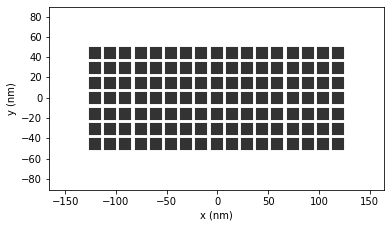

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:835: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


        - champion fitness: [-14.484]

iter #  2, time:   49.9s, progress #  2, f_evals: 75


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/EO/models.py:155: UserWarning: 'models.BaseModel.plot_structure' not re-implemented! Using `pyGDM2.visu.structure`.
  warnings.warn("'models.BaseModel.plot_structure' not re-implemented! Using `pyGDM2.visu.structure`.")


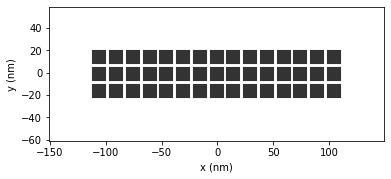

        - champion fitness: [-26.052]

iter #  3, time:   63.0s, progress #  2, f_evals: 100(non-success: 1)

 -------- timelimit reached


In [4]:
eo_dict = run_eo(problem,
                 population=population,
                 algorithm=algorithm,
                 plot_interval=plot_interval, 
                 generations=generations, 
                 max_time=max_time, max_iter=max_iter, max_nonsuccess=max_nonsuccess,
                 filename=results_filename)

The output will look something like this.

**Note:** In this run, the optimum structure was already found in the third generation, it may even happen to be in the randomized initial population, since there are only 2 free parameters which are furthermore very constrained. For more complex structure models, the probability of this to happen will of course be very low.


Post-processing of optimum solution
-------------------------------------------

Now we want to calculate the scattering spectrum for the optimum solution. We will load the simulation from the files, generated by *do_eo*. Then we create a new simulation with a spectrum of wavelengths.

In [5]:
## --- load additional modules
from pyGDM2.EO.tools import get_best_candidate
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

import copy
import numpy as np
import matplotlib.pyplot as plt

#==============================================================================
# load the final fittest candidate (=optimum geometry)
#==============================================================================
## --- optimization results file
results_filename = 'eo_Qscat.eo'

sim = get_best_candidate(results_filename, iteration=-1, verbose=True)

Best candidate after 3 iterations (with 1 improvements): fitness = ['-26.052']
Testing: recalculating fitness...Done. Everything OK.


**Note:** We loaded the best candidate from *iteration* Nr "-1"., which is the last iteration of the evolution ("-2" would be second last and so on; positive numbers starting from "0" can be used as well, this is just python indexing.).

In [6]:
#==============================================================================
# setup new simulation to calculate spectrum
#==============================================================================
## --- structure
struct = copy.deepcopy(sim.struct)

## --- incident field
field_generator = fields.planewave        # planwave excitation
wavelengths = np.arange(600, 1410, 30)    # spectrum
kwargs = dict(theta = [0.0, 90.0])        # 0 / 90 deg polarizations
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## --- env.
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)

## --- simulation
sim_spectrum = core.simulation(struct, efield, dyads)


#==============================================================================
# run simulation for the spectrum
#==============================================================================
core.scatter(sim_spectrum, verbose=False)

## --- calculate the spectrum for X and Y polarization
wl, spec_ext0 = tools.calculate_spectrum(sim_spectrum, 0, linear.extinct)
asca0 = spec_ext0.T[1]

wl, spec_ext90 = tools.calculate_spectrum(sim_spectrum, 1, linear.extinct)
asca90 = spec_ext90.T[1]

geom_cs = tools.get_geometric_cross_section(sim_spectrum)

Plot the scattering spectrum for the best solution
------------------------------------------

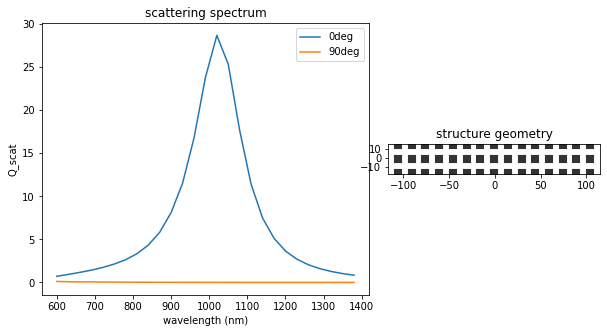

In [7]:
## --- plot
plt.figure(figsize=(10,5))

## --- spectra
plt.subplot2grid((1,5), (0,0), colspan=3)
plt.title("scattering spectrum")
plt.plot(wl, asca0/geom_cs, label="0deg")
plt.plot(wl, asca90/geom_cs, label="90deg")

plt.legend(loc='best', fontsize=10)
plt.xlabel("wavelength (nm)")
plt.ylabel("Q_scat")

## --- structure
plt.subplot2grid((1,5), (0,3), colspan=2, aspect="equal")
plt.title('structure geometry')
visu.structure(sim_spectrum, show=False)
    
plt.show()

Indeed, a structure was found which has a strong plasmon resonance at the target wavelength of 1000nm.